## <center> House Price - Best Approach Taken

In [20]:
#Import packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb

import sklearn
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score
from sklearn.linear_model import Ridge, Lasso, RidgeCV, LassoCV, ElasticNetCV, ElasticNet
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.metrics import mean_squared_error

from scipy import stats
from scipy.stats import skew, norm
from scipy.special import boxcox1p

#Handle warnings
import warnings
warnings.filterwarnings('ignore')

#Set precision to 4 decimals
%precision 4

'%.4f'

In [3]:
#Read dataset
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

In [4]:
#Review train data
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
#Review test data
df_test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [6]:
#Review shape of dataset
df_train.shape, df_test.shape

((1460, 81), (1459, 80))

## Backup the original data as we might mess it up in the process

In [7]:
df_train_copy = df_train.copy()
df_test_copy = df_test.copy()

### Find Null Values

In [17]:
totalrows = df_train.shape[0]
total = df_train.isnull().sum().sort_values(ascending=False)
percent = round(df_train.isnull().sum().sort_values(ascending=False)/totalrows*100,2)
train_nas = pd.concat([total, percent], keys=['Total', 'Percent'], axis=1)
train_nas.head()

,Total,Percent
PoolQC,1453,99.52
MiscFeature,1406,96.30
Alley,1369,93.77
Fence,1179,80.75
FireplaceQu,690,47.26


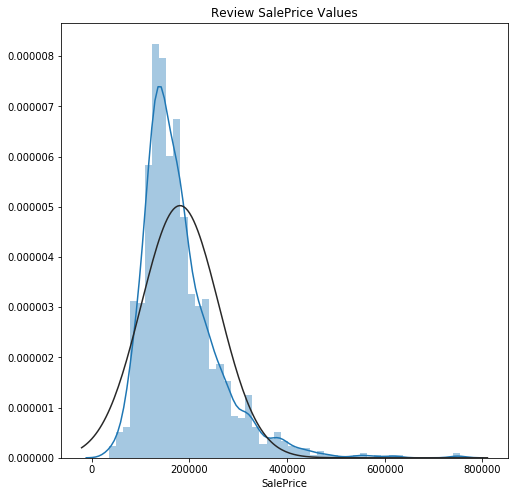

In [18]:
#Plot target variable
plt.figure(figsize=(8,8))
sb.distplot(df_train['SalePrice'], fit=norm)
plt.title('Review SalePrice Values')
plt.show();

In [28]:
# plt.figure(figsize=(6,5))
stats.probplot(df_train['SalePrice'], dist=norm)
plt.show()

In [35]:
print('Skewness of Target Variable:', df_train['SalePrice'].skew())
print('Kurtosis of Target Variable:', df_train['SalePrice'].kurt())

Skewness of Target Variable: 1.8828757597682129
Kurtosis of Target Variable: 6.536281860064529


#### Skewness

is the degree of distortion from the symmetrical bell curve or the normal curve.
So, a symmetrical distribution will have a skewness of "0".
<br>
<li> There are two types of Skewness: Positive and Negative.
<li> Positive Skewness(similar to our target variable distribution) means the tail on the right side of the distribution is longer and fatter.
<li> In positive Skewness the mean and median will be greater than the mode. This is similar to this dataset. So, in Layman's terms, more houses were sold by less than the average price.
<li> Negative Skewness means the tail on the left side of the distribution is longer and fatter.
<li> In negative Skewness the mean and median will be less than the mode.
<li>Skewness differentiates extreme values in one versus the other tail.
<img src=img/Skewness.jpeg>
    
#### Kurtosis

It is the measure of the extreme values(outliers) present in the distribution.
<br>
<li>There are three types of Kurtosis: Mesokurtic, Leptokurtic and Platykurtic.
<li>Mesokurtic is similar to normal curve with the standard value of 3. This means that the extreme values of this distrubution is similar to that of a normal distribution.
<li>Leptokurtic Example of leptokurtic distributions are the T-distributions with small degrees of freedom.
<li>Platykurtic: Platykurtic describes a particular statistical distribution with thinner tails than a normal distribution. Because this distribution has thin tails, it has fewer outliers (e.g., extreme values three or more standard deviations from the mean) than do mesokurtic and leptokurtic distributions.
<img src=img/KurtosisPict.jpg
    
Credits - https://www.kaggle.com/masumrumi/a-detailed-regression-guide-with-house-pricing